# CMPAS数据升尺度及屏蔽中国外区域

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import shutil
import warnings
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy
from nmc_met_graphics.cmap.ctables import cm_qpf_nws
warnings.filterwarnings('ignore')

## 升尺度CMPAS区域数据（Linux下运行）

In [ ]:
data_dir = pathlib.Path("/media/kan-dai/MESO/CMPAS/2018/0P05")
out_dir = pathlib.Path("/media/kan-dai/MESO/CMPAS/2018/0P10/")

In [ ]:
# create xESMF regridder

import xesmf as xe

ds_in = xr.open_dataset(data_dir.joinpath(
    "Z_SURF_C_BABJ_20180712040012_P_CMPA_NRT_CHN_0P05_HOR-PRE-2018071017.rain.nc"))
ds_in = ds_in.rename({"longitude":"x", "latitude":"y"})
x = ds_in.coords['x'].values
y = ds_in.coords['y'].values
dx = x[1] - x[0]
dy = y[1] - y[0]
lon, lat = np.meshgrid(x, y)
ds_in.coords['lon'] = (("y", "x"), lon)
ds_in.coords['lat'] = (("y", "x"), lat)
lon_b = np.append((x - dx*0.5), x[-1]+dx*0.5)
lat_b = np.append((y - dy*0.5), y[-1]+dy*0.5)
lon_b, lat_b = np.meshgrid(lon_b, lat_b)
ds_in.coords['lon_b'] = (("y_b", "x_b"), lon_b)
ds_in.coords['lat_b'] = (("y_b", "x_b"), lat_b)

# output grid
x = np.arange(102, 135.05, 0.1)
y = np.arange(50, 16.95, -0.1)
dx = x[1] - x[0]
dy = y[1] - y[0]
lon, lat = np.meshgrid(x, y)
lon_b = np.append((x - dx*0.5), x[-1]+dx*0.5)
lat_b = np.append((y - dy*0.5), y[-1]+dy*0.5)
lon_b, lat_b = np.meshgrid(lon_b, lat_b)
ds_out = xr.Dataset(
    {'x': (['x'], x), 'y': (['y'], y)},
    coords={'lon': (("y", "x"), lon), 
            'lat': (("y", "x"), lat),
            'lon_b': (("y_b", "x_b"), lon_b),
            'lat_b': (("y_b", "x_b"), lat_b)})

# construct regridder
regridder = xe.Regridder(ds_in, ds_out, 'conservative', periodic=False)

In [ ]:
# loop every file and regrid
for file in data_dir.glob("*.rain.nc"):
    outfile = out_dir.joinpath(file.name.replace('_0P05_','_0P10_'))
    if outfile.is_file():
        continue
    ds = xr.open_dataset(file)
    ds_out = xr.Dataset(
        {'x': (['x'], x), 'y': (['y'], y)},
        coords={'lon': (("y", "x"), lon), 
                'lat': (("y", "x"), lat),
                'lon_b': (("y_b", "x_b"), lon_b),
                'lat_b': (("y_b", "x_b"), lat_b)})
    ds_out['rain'] = regridder(ds['rain'])
    ds_out.rename({'x':'longitude', 'y':'latitude'}).to_netcdf(outfile)
    

## 屏蔽中国外区域

In [3]:
# set data and output directory
data_dir = pathlib.Path("I:/CMPAS/2018/0P01/")
out_dir = pathlib.Path("I:/CMPAS/2018/0P10/")

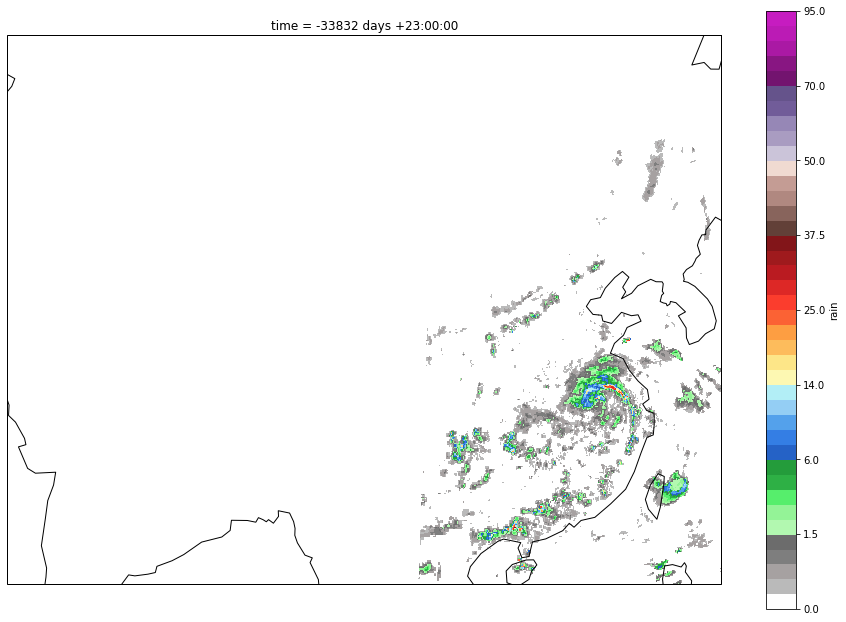

In [4]:
file = pathlib.Path("I:/CMPAS/2018/0P10/Z_SURF_C_BABJ_20180819025206_P_CMPA_NRT_CHN_0P10_HOR-PRE-2018081712.rain.nc")
ds = xr.open_dataset(file)

fig = plt.figure(figsize=(16,11))
datacrs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=105))
ax.set_extent((70, 125, 18, 56),crs=datacrs)
cmap, norm = cm_qpf_nws(atime=1)
ds['rain'].isel(time=0).plot(ax=ax, transform=datacrs, norm=norm, cmap=cmap)
ax.coastlines()
plt.show()